# <center> Conditional logic with the QICK demonstration

In this demo you will send and receive a pulse in loopback conditional on the value of a number written to the QICK. A similar application of the QICK conditional logic can enable the active reset of qubits. 

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.qick_asm import *
from qick.averager_program import *
from qick.helpers import gauss
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
# Set the loopback DAC channel to be in 1st Nyquist zone mode
soc.set_nyquist(ch=7,nqz=1); 

### Hardware Configuration

tProc channel 7   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0


In [3]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[adcfreq(self.cfg["pulse_freq"])]*2   #add frequency of adc ddc to config
        
        # Set threshold
        self.regwi(0,1,self.cfg["threshold"])

        # Set value of number 
        self.regwi(0,2,self.cfg["number"])

        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library
        
        freq=freq2reg(adcfreq(cfg["pulse_freq"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        
        # Apply conditional logic statement: When number is smaller than threshold, skip over playing the pulse.
        self.condj(0,2,'<',1,'LABEL') 
        self.pulse(ch=self.cfg["res_ch"], length=self.cfg["length"], play=True) # play readout pulse
        self.label('LABEL')

        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # sync all channels

### When the value of <code> number </code> is above the threshold, the conditional statement is False so you see a loopback pulse.

In [4]:
config={"res_ch":7, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":0, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "length":20, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":1000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":100,
        ### New variables
        "number": 100,
        "threshold": 50
       }

prog =LoopbackProgram(config)
di0, dq0, di1, dq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

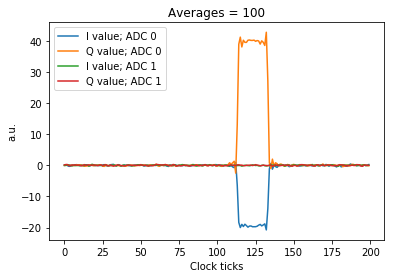

In [5]:
# Plot results.
plt.figure(1)
plt.plot(di0, label="I value; ADC 0")
plt.plot(dq0, label="Q value; ADC 0")
plt.plot(di1, label="I value; ADC 1")
plt.plot(dq1, label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Conditional_False_Pulse.pdf", dpi=350)

### When the value of <code> number </code> is below the threshold, the conditional statement is True so you don't see a loopback pulse.

In [6]:
config["number"]=10

prog =LoopbackProgram(config)
di0, dq0, di1, dq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

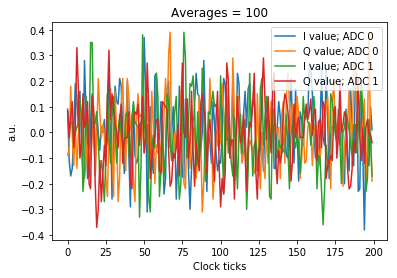

In [7]:
# Plot results.
plt.figure(1)
plt.plot(di0, label="I value; ADC 0")
plt.plot(dq0, label="Q value; ADC 0")
plt.plot(di1, label="I value; ADC 1")
plt.plot(dq1, label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Conditional_True_NoPulse.pdf", dpi=350)